In [1]:
import math
import joblib
import keras
import scipy

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from keras import activations, layers, initializers
from keras.models import Model
import h5py

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
class MatReader(object):
    def __init__(self, file_path, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_float(self, to_float):
        self.to_float = to_float

In [3]:
PATH = '../data/Darcy_Triangular_FNO_multifid_hmax018_hmin016.mat'
reader = MatReader(PATH)

r = 2
h = int(((101 - 1)/r) + 1)
s = h

n_total = 500
n_train = 250
n_test = n_total-n_train

x_read = np.array(reader.read_field('boundCoeff')[:,::r,::r][:,:s,:s])
y_read = np.array(reader.read_field('sol')[:,::r,::r][:,:s,:s])

# HF training data
x = x_read[:n_total].reshape((n_total, 1, s, s))  # X input
y = y_read[:n_total].reshape((n_total, s, s, 1))  # HF output
x_train, y_train = x[:n_train, ...], y[:n_train, ...]
x_test, y_test = x[-n_test:, ...], y[-n_test:, ...]

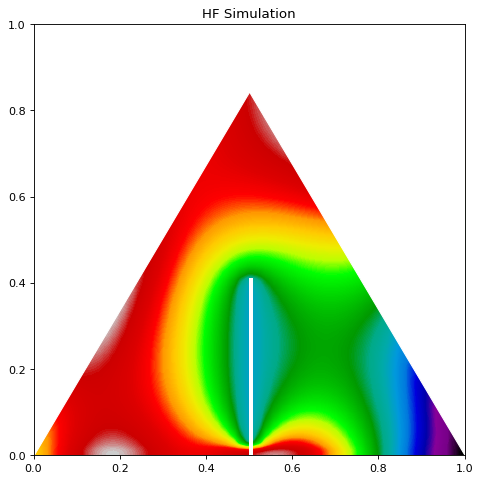

In [4]:
s_disp = 1
xmax = s_disp
ymax = s_disp-8/51
value = 17

fig1 = plt.figure(figsize=(7,7), dpi=80)
plt.imshow(y_train[value,:,:], origin='lower', extent = [0, 1, 0, 1], interpolation='Gaussian', cmap='nipy_spectral')
plt.title('HF Simulation')
        
xf = np.array([0., xmax/2]); yf = xf*(ymax/(xmax/2)); plt.fill_between(xf, yf, ymax, color = [1, 1, 1])
xf = np.array([xmax/2, xmax]); yf = (xf-xmax)*(ymax/((xmax/2)-xmax)); plt.fill_between(xf, yf, ymax, color = [1, 1, 1])
xf = np.array([0, xmax]); plt.fill_between(xf, ymax, s_disp, color = [1, 1, 1])        
plt.gca().add_patch(Rectangle((0.5,0),0.01,0.41, facecolor='white'))

In [5]:
# x space
xspace = np.linspace(0,1,51,endpoint=False)
gridspace = np.meshgrid(xspace,xspace)
x_grid = gridspace[0].reshape(51**2,1)
y_grid = gridspace[1].reshape(51**2,1)

x1_grid_train = np.tile(x_grid,(n_train,1,1))
x2_grid_train = np.tile(y_grid,(n_train,1,1))
x1_grid_test = np.tile(x_grid,(n_test,1,1))
x2_grid_test = np.tile(y_grid,(n_test,1,1))

x_grid_train = np.concatenate([x2_grid_train,x1_grid_train], axis=-1)
x_grid_test = np.concatenate([x2_grid_test,x1_grid_test], axis=-1)

In [6]:
x_train = x_train.reshape((n_train,1,51**2))
y_train = y_train.reshape((n_train,51**2,1))

In [7]:
print(f"Input field shape: {x_train.shape}")
print(f"Output field shape: {y_train.shape}")
print(f"Position field shape: {x_grid_train.shape}")

Input field shape: (250, 1, 2601)
Output field shape: (250, 2601, 1)
Position field shape: (250, 2601, 2)


In [8]:
def build_mlp(inputs, output_features: int, 
              hidden_features: int, num_hidden_layers: int):
    """
    Builds an MLP regression model.
    
    Parameters:
        x: Input tensor.
        output_features (int): Number of output features.
        hidden_features (int): Number of units in each hidden layer.
        num_hidden_layers (int): Number of hidden layers.
    
    Returns:
        array: keras tensor.
    """
    x = inputs
    
    # Create hidden layers with tanh activation
    for _ in range(num_hidden_layers):
        x = layers.Dense(hidden_features, activation='leaky_relu')(x)
    
    # Output layer with linear activation for regression
    outputs = layers.Dense(output_features, activation='linear')(x)
    
    return outputs

In [9]:
def deeponet(y_in_size, u_in_size, trunk_params, branch_params, out_feat=1):
    """_summary_

    Args:
        y_in_size (tuple): spatial input size
        u_in_size (tuple): function input size
        trunk_params (dict): trunk net parameters
        branch_params (dict): branch net parameters
        out_feat (int, optional): number of output feature. Defaults to 1.

    Returns:
        keras.Model: output model
    """
    y_input = layers.Input(y_in_size)
    u_input = layers.Input(u_in_size)

    # Trunk layer
    trunk_out = build_mlp(y_input, trunk_params["output_features"], 
                          trunk_params["hidden_features"], trunk_params["num_hidden_layers"])
    
    # Branch layer
    branch_out = build_mlp(u_input, branch_params["output_features"], 
                          branch_params["hidden_features"], branch_params["num_hidden_layers"])

    # Multiply trunk and branch
    mult_out = layers.Multiply()([branch_out, trunk_out])

    out = layers.Dense(out_feat,use_bias=False)(mult_out)

    model = Model(inputs=[y_input, u_input], outputs=out, name="DeepONet")

    return model


In [10]:
trunk_params=dict()
trunk_params["output_features"] = 128
trunk_params["hidden_features"] = 128
trunk_params["num_hidden_layers"] = 2

branch_params=dict()
branch_params["output_features"] = 128
branch_params["hidden_features"] = 128
branch_params["num_hidden_layers"] = 1

In [11]:
onet = deeponet(y_in_size=(51**2,2), u_in_size=(1,51**2), trunk_params=trunk_params, 
                branch_params=branch_params, out_feat=1)
onet.summary()

2025-02-27 09:49:22.808321: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-27 09:49:22.808346: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-27 09:49:22.808350: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-02-27 09:49:22.808595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-27 09:49:22.808948: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "DeepONet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2601, 2)]            0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1, 2601)]            0         []                            
                                                                                                  
 dense (Dense)               (None, 2601, 128)            384       ['input_1[0][0]']             
                                                                                                  
 dense_3 (Dense)             (None, 1, 128)               333056    ['input_2[0][0]']             
                                                                                           

In [12]:
def scheduler(epoch):
    if epoch < 2000:
        lr = 0.001
    elif epoch < 10000:
        lr = 0.0005
    else:
        lr = 0.0001
    
    return lr

In [13]:
callback = keras.callbacks.LearningRateScheduler(scheduler)
onet.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=["mse"]
)

In [14]:
history = onet.fit(x=[x_grid_train,x_train], y=y_train, batch_size=256, epochs=5000, callbacks=[callback], verbose=1)

Epoch 1/5000


2025-02-27 09:49:23.480713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.7199 - mse: 0.7199 - lr: 0.0010
Epoch 2/5000
1/1 [==============================] - 0s 356ms/step - loss: 0.4009 - mse: 0.4009 - lr: 0.0010
Epoch 3/5000
1/1 [==============================] - 0s 344ms/step - loss: 0.3655 - mse: 0.3655 - lr: 0.0010
Epoch 4/5000
1/1 [==============================] - 0s 341ms/step - loss: 0.3164 - mse: 0.3164 - lr: 0.0010
Epoch 5/5000
1/1 [==============================] - 0s 343ms/step - loss: 0.3182 - mse: 0.3182 - lr: 0.0010
Epoch 6/5000
1/1 [==============================] - 0s 342ms/step - loss: 0.2566 - mse: 0.2566 - lr: 0.0010
Epoch 7/5000
1/1 [==============================] - 0s 340ms/step - loss: 0.2521 - mse: 0.2521 - lr: 0.0010
Epoch 8/5000
1/1 [==============================] - 0s 339ms/step - loss: 0.2660 - mse: 0.2660 - lr: 0.0010
Epoch 9/5000
1/1 [==============================] - 0s 340ms/step - loss: 0.2426 - mse: 0.2426 - lr: 0.0010
Epoch 10/5000
1/1 [=========================

In [15]:
x_test.shape

(250, 1, 51, 51)

In [16]:
x_test = x_test.reshape((n_test,1,51**2))

In [17]:
preds = onet.predict([x_grid_test, x_test])

8/8 [==============================] - 1s 38ms/step


In [18]:
y_test.shape

(250, 51, 51, 1)

In [19]:
preds = preds.reshape((n_test,51,51,1))

In [20]:
abs_error = np.abs(y_test-preds)

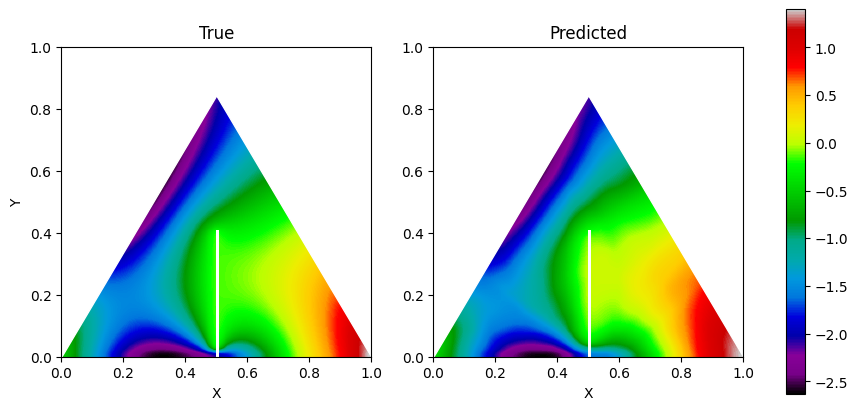

RMSE overall = 0.027559006586670876


In [21]:
s_disp = 1
xmax = s_disp
ymax = s_disp-8/51
value = 7

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
# Interpolated LF
im = ax[0].imshow(y_test[value,:,:], origin='lower', extent = [0, 1, 0, 1], interpolation='Gaussian', cmap='nipy_spectral',
                  )
ax[0].set_title('True')

xf1 = np.array([0., xmax/2]) 
yf1 = xf1*(ymax/(xmax/2)) 
ax[0].fill_between(xf1, yf1, ymax, color = [1, 1, 1])
xf1 = np.array([xmax/2, xmax]) 
yf1 = (xf1-xmax)*(ymax/((xmax/2)-xmax))
ax[0].fill_between(xf1, yf1, ymax, color = [1, 1, 1])
xf1 = np.array([0, xmax]) 
ax[0].fill_between(xf1, ymax, s_disp, color = [1, 1, 1])        
ax[0].add_patch(Rectangle((0.5,0),0.01,0.41, facecolor='white'))
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")

# HF
im = ax[1].imshow(preds[value,:,:], origin='lower', extent = [0, 1, 0, 1], interpolation='Gaussian', cmap='nipy_spectral',
                  )
ax[1].set_title('Predicted')

xf2 = np.array([0., xmax/2]) 
yf2 = xf2*(ymax/(xmax/2)) 
ax[1].fill_between(xf2, yf2, ymax, color = [1, 1, 1])
xf2 = np.array([xmax/2, xmax]) 
yf2 = (xf2-xmax)*(ymax/((xmax/2)-xmax))
ax[1].fill_between(xf2, yf2, ymax, color = [1, 1, 1])
xf2 = np.array([0, xmax]) 
ax[1].fill_between(xf2, ymax, s_disp, color = [1, 1, 1])        
ax[1].add_patch(Rectangle((0.5,0),0.01,0.41, facecolor='white'))
ax[1].set_xlabel("X")
# ax[1].set_ylabel("Y")

fig.colorbar(im, ax=ax.ravel().tolist())

rmse = np.sqrt(np.mean((y_test - preds)**2))

plt.show()

print(f"RMSE overall = {rmse}")


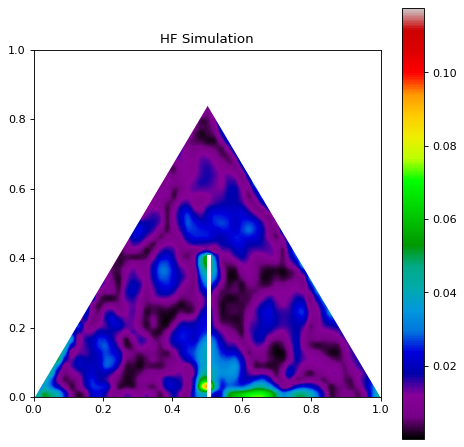

In [22]:
s_disp = 1
xmax = s_disp
ymax = s_disp-8/51
value = 17

fig1 = plt.figure(figsize=(7,7), dpi=80)
plt.imshow(abs_error[value,:,:], origin='lower', extent = [0, 1, 0, 1], interpolation='Gaussian', cmap='nipy_spectral')
plt.title('HF Simulation')
        
xf = np.array([0., xmax/2]); yf = xf*(ymax/(xmax/2)); plt.fill_between(xf, yf, ymax, color = [1, 1, 1])
xf = np.array([xmax/2, xmax]); yf = (xf-xmax)*(ymax/((xmax/2)-xmax)); plt.fill_between(xf, yf, ymax, color = [1, 1, 1])
xf = np.array([0, xmax]); plt.fill_between(xf, ymax, s_disp, color = [1, 1, 1])        
plt.gca().add_patch(Rectangle((0.5,0),0.01,0.41, facecolor='white'))

plt.colorbar()

In [23]:
np.mean(abs_error[value,:,:])

0.012843354

In [24]:
np.mean(y_test[value,:,:])

0.09982116